# Keras Train NN Classifier for FANET Reliability
Date: 03/03/2023
Desc: To train a NN classifier to predict FANET reliability and failure modes

## Import libs

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Model
from keras.layers import Dense, Input
from keras.utils import to_categorical 
import pickle, os


ModuleNotFoundError: No module named 'tensorflow'

## Set params and Load Dataset

In [10]:
# Training params
EPOCHS = 10
TEST_SPLIT = 0.10 # Test split percentage
checkpoint_filepath = '/home/research-student/omnet-fanet/nn_checkpoints/nn_v2_hovering_novideo_sinr'
delay_threshold = 0.04 # NOTE: REMEMBER TO SET DELAY THRESHOLD

# Compile all data
# dl_df_8uav = pd.read_hdf("/home/rlim0005/FANET_Dataset/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_8UAVs_processed_downlink.h5", '8_UAVs')
# dl_df_16uav = pd.read_hdf("/home/rlim0005/FANET_Dataset/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_16UAVs_processed_downlink.h5", '16_UAVs')
# dl_df_24uav = pd.read_hdf("/home/rlim0005/FANET_Dataset/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_24UAVs_processed_downlink.h5", '24_UAVs')
# dl_df_32uav = pd.read_hdf("/home/rlim0005/FANET_Dataset/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_32UAVs_processed_downlink.h5", '32_UAVs')
# dl_df_40uav = pd.read_hdf("/home/rlim0005/FANET_Dataset/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_40UAVs_processed_downlink.h5", '40_UAVs')
# dl_df = pd.concat([dl_df_8uav, dl_df_16uav, dl_df_24uav, dl_df_32uav, dl_df_40uav], ignore_index=True)

dl_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_64QAM_65Mbps_Hovering_NoVideo/8UAVs_Exp1_processed_downlink.csv")

dl_df.sort_values(by = "U2G_H_Dist")

data_df = dl_df[["Mean_SINR", "Std_Dev_SINR", "Num_Members", "Bytes", "UAV_Sending_Interval", "Incorrectly_Received", "Queue_Overflow"]].copy()
data_df["Reliable"] = np.where(dl_df['Packet_State'] == "Reliable" , 1, 0)
data_df["Delay_Exceeded"] = np.where(dl_df['Delay'] > delay_threshold, 1, 0)

## Load and pre-process data

In [11]:
# Normalize data
max_mean_sinr = 521 # The max mean SINR calculated at (50,60) is 520.2907250903191
max_std_dev_sinr = 252 # The max std dev SINR calculated at (50,60) is 251.44889082897834
max_num_members = 39
max_bytes = 1500 # Max Ethernet MTU
# NOTE: Sending interval is already between 0 and 1 in the data
data_df["Mean_SINR"] = data_df["Mean_SINR"].div(max_mean_sinr)
data_df["Std_Dev_SINR"] = data_df["Std_Dev_SINR"].div(max_std_dev_sinr)
data_df["Num_Members"] = data_df["Num_Members"].div(max_num_members)
data_df["Bytes"] = data_df["Bytes"].div(max_bytes)

# Split to train and test
data_df_train, data_df_test = train_test_split(data_df, test_size=TEST_SPLIT, random_state=40, shuffle=False)
X_train = data_df_train[["Mean_SINR", "Std_Dev_SINR", "Num_Members", "Bytes", "UAV_Sending_Interval"]].values
X_test = data_df_test[["Mean_SINR", "Std_Dev_SINR", "Num_Members", "Bytes", "UAV_Sending_Interval"]].values
X_train_all = data_df[["Mean_SINR", "Std_Dev_SINR", "Num_Members", "Bytes", "UAV_Sending_Interval"]].values
reliability_train = data_df_train["Reliable"].values
reliability_test = data_df_test["Reliable"].values
reliability_train_all = data_df["Reliable"].values
incr_rcvd_train = data_df_train["Incorrectly_Received"].values
incr_rcvd_test = data_df_test["Incorrectly_Received"].values
incr_rcvd_train_all = data_df["Incorrectly_Received"].values
delay_excd_train = data_df_train["Delay_Exceeded"].values
delay_excd_test = data_df_test["Delay_Exceeded"].values
delay_excd_train_all = data_df["Delay_Exceeded"].values
queue_overflow_train = data_df_train["Queue_Overflow"].values
queue_overflow_test = data_df_test["Queue_Overflow"].values
queue_overflow_train_all = data_df["Queue_Overflow"].values

reliability_train = to_categorical(reliability_train) 
reliability_test = to_categorical(reliability_test)
reliability_train_all = to_categorical(reliability_train_all) 
incr_rcvd_train = to_categorical(incr_rcvd_train) 
incr_rcvd_test = to_categorical(incr_rcvd_test)
incr_rcvd_train_all = to_categorical(incr_rcvd_train_all) 
delay_excd_train = to_categorical(delay_excd_train) 
delay_excd_test = to_categorical(delay_excd_test)
delay_excd_train_all = to_categorical(delay_excd_train_all)
queue_overflow_train = to_categorical(queue_overflow_train) 
queue_overflow_test = to_categorical(queue_overflow_test)
queue_overflow_train_all = to_categorical(queue_overflow_train_all)

## Train the model

In [12]:
# For multiple output model
# Version 2: Add an additional hidden layer for each output layer (not shared among outputs)
inputs = Input(shape=(5,))
base = Dense(50, activation='relu')(inputs)
base = Dense(25, activation='relu')(base)
base = Dense(10, activation='relu')(base)
reliability_hl = Dense(10, activation='relu')(base)
incr_rcvd_out_hl = Dense(10, activation='relu')(base)
delay_excd_hl = Dense(10, activation='relu')(base)
queue_overflow_hl = Dense(10, activation='relu')(base)
reliability_out = Dense(2, activation='softmax', name='reliability')(reliability_hl)
incr_rcvd_out = Dense(8, activation='softmax', name='incorrectly_received')(incr_rcvd_out_hl)
delay_excd_out = Dense(2, activation='softmax', name='delay_exceeded')(delay_excd_hl)
queue_overflow_out = Dense(2, activation='softmax', name='queue_overflow')(queue_overflow_hl)
model = Model(inputs=inputs, outputs = [reliability_out, incr_rcvd_out, delay_excd_out, queue_overflow_out])

# Load pre-trained model for finetuning
# model = tf.keras.models.load_model(os.path.join(checkpoint_filepath, "model.010-2.0158.h5"), compile=False)

# Compile the model
model.compile(optimizer='adam', 
              loss={'reliability': 'binary_crossentropy',
                    'incorrectly_received': 'categorical_crossentropy',
                    'delay_exceeded': 'binary_crossentropy',
                    'queue_overflow': 'binary_crossentropy'},
              metrics={'reliability': 'accuracy',
                    'incorrectly_received': 'accuracy',
                    'delay_exceeded': 'accuracy',
                    'queue_overflow': 'accuracy'},)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath,"model.{epoch:03d}-{val_loss:.4f}.h5"),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_freq='epoch')

# Y_train = [reliability_train, incr_rcvd_train, delay_excd_train, queue_overflow_train]
Y_train_all = [reliability_train_all, incr_rcvd_train_all, delay_excd_train_all, queue_overflow_train_all]
Y_test = [reliability_test, incr_rcvd_test, delay_excd_test, queue_overflow_test]
history = model.fit(X_train_all, Y_train_all, epochs=EPOCHS, callbacks=[model_checkpoint_callback], validation_data=(X_test, Y_test))
with open(os.path.join(checkpoint_filepath, 'trainHistoryDict_18042023'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Save final model
model.save(os.path.join(checkpoint_filepath,"final_model.h5"))

Epoch 1/10
6765/6765 [==============================] - 28s 4ms/step - loss: 0.9760 - reliability_loss: 0.0809 - incorrectly_received_loss: 0.4087 - delay_exceeded_loss: 0.2577 - queue_overflow_loss: 0.2287 - reliability_accuracy: 0.9680 - incorrectly_received_accuracy: 0.9039 - delay_exceeded_accuracy: 0.9117 - queue_overflow_accuracy: 0.9215 - val_loss: 0.5808 - val_reliability_loss: 0.0015 - val_incorrectly_received_loss: 0.2181 - val_delay_exceeded_loss: 0.1811 - val_queue_overflow_loss: 0.1801 - val_reliability_accuracy: 0.9999 - val_incorrectly_received_accuracy: 0.9563 - val_delay_exceeded_accuracy: 0.9563 - val_queue_overflow_accuracy: 0.9563
Epoch 2/10
6765/6765 [==============================] - 26s 4ms/step - loss: 0.8835 - reliability_loss: 0.0504 - incorrectly_received_loss: 0.3828 - delay_exceeded_loss: 0.2433 - queue_overflow_loss: 0.2071 - reliability_accuracy: 0.9801 - incorrectly_received_accuracy: 0.9068 - delay_exceeded_accuracy: 0.9204 - queue_overflow_accuracy: 0.

In [5]:
import pickle

with (open("/home/research-student/omnet-fanet/nn_checkpoints/trainHistoryDict", "rb")) as file:
    history = pickle.load(file)

In [2]:
import pandas as pd
import sys
dl_df_8uav = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_8UAVs_processed_downlink.h5", '8_UAVs')
dl_df_16uav = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_16UAVs_processed_downlink.h5", '16_UAVs')
dl_df_24uav = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_24UAVs_processed_downlink.h5", '24_UAVs')
dl_df_32uav = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_32UAVs_processed_downlink.h5", '32_UAVs')
dl_df_40uav = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_BPSK_6-5Mbps/Dataset_NP10000_BPSK_6-5Mbps_40UAVs_processed_downlink.h5", '40_UAVs')
dl_df = pd.concat([dl_df_8uav, dl_df_16uav, dl_df_24uav, dl_df_32uav, dl_df_40uav], ignore_index=True)
sys.getsizeof(dl_df)

3777499685

# Plot Training Progress

Text(0.5, 1.0, 'Training Progress for NN V4 with SINR Input')

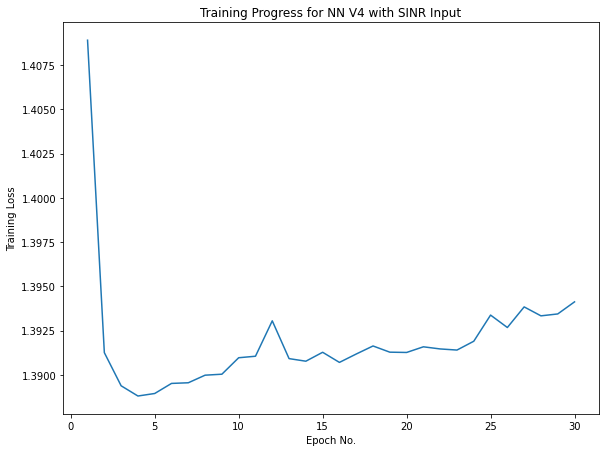

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with (open("/home/research-student/omnet-fanet/nn_checkpoints/nn_v3_hovering_sinr/trainHistoryDict_04042023", "rb")) as file:
    history1 = pickle.load(file)

with (open("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2-2_21032023/trainHistoryDict_21032023", "rb")) as file:
    history2 = pickle.load(file)

loss1 = history1["loss"]
epoch1 = np.linspace(1,len(loss1), len(loss1), dtype="int16")
loss2 = history2["loss"]
epoch2 = np.linspace(1,len(loss2), len(loss2), dtype="int16")

fig = plt.figure(figsize=(9.6, 7.2))
ax_loss = fig.subplots()
plt.plot(epoch1, loss1)
# plt.plot(epoch2, loss2)
plt.xlabel("Epoch No.")
plt.ylabel("Training Loss")
# plt.title("Plot of Training Loss vs Epoch for NN")
plt.title("Training Progress for NN V4 with SINR Input")
# plt.legend(("V2", "V3"))